In [1]:
!cd

D:\Ansys Simulations\Project\2D\preprocessing


## Formatting
In this notebook, the objective is to explore and develop a way to transformed the scaled data into a relevant data format/file/shape that can be used for a 2d convolutional neural network. Ideally, what is desired is a file that can store tensors as spatial data and that can be used by a ConvNet.
After some research, the conclusion is that the best way to do this is to format them as a 4D numpy array and saved as a .npy file so that they can be later quickly read into memory.

In [692]:
## Imports
import numpy as np

import PREPROCESSING_scaling as scale
from pathlib import Path
import pandas as pd
import os, sys
import torch.nn.functional as F
import torch
import warnings

In [2]:
## 3d visualization import
%gui qt
from mayavi import mlab
mlab.init_notebook('png')

Notebook initialized with png backend.


In [709]:
from importlib import reload 
import PREPROCESSING_splitting as split
reload(split)

splitting functions imported


<module 'PREPROCESSING_splitting' from 'D:\\Ansys Simulations\\Project\\2D\\preprocessing\\PREPROCESSING_splitting.py'>

In [3]:
## load in and scale  a sample

data_folder_path =  Path('D:/Ansys Simulations/Project/2D/data') 

# get data
raw_input_data, raw_output_data = scale.get_sample_dfs(data_folder_path, 26)

max_force, max_disp = scale.get_max_disp_force(data_folder_path)

scaled_input_data = scale.scale_dataframe(raw_input_data, max_force, max_disp)
with pd.option_context("display.max_rows", None):
    display(scaled_input_data.iloc[170:189,:])

UPDATED MAX 	 sample #1 	 force: 0.00 	 displacement: 0.002053 
UPDATED MAX 	 sample #10 	 force: 152.79 	 displacement: 0.003020 
UPDATED MAX 	 sample #100 	 force: 152.79 	 displacement: 0.019382 
UPDATED MAX 	 sample #101 	 force: 242.87 	 displacement: 0.019382 
UPDATED MAX 	 sample #11 	 force: 287.27 	 displacement: 0.019382 
UPDATED MAX 	 sample #55 	 force: 295.32 	 displacement: 0.019382 


,node_number,named_selection,x_loc,y_loc,z_loc,x_disp,y_disp,z_disp,x_force,y_force,z_force
170,171,-1,0.180590,0.242730,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
171,172,-1,0.138780,0.205680,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
172,173,-1,0.068634,0.123060,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
173,174,-1,0.054411,0.084662,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
174,175,-1,0.024266,0.072970,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
175,176,2,0.328590,0.694900,0.0,-0.050859,-0.107693,0.0,0.0,0.0,0.0
176,177,1,0.189800,0.568730,0.0,0.031275,-0.014854,0.0,0.0,0.0,0.0
177,178,1,0.127090,0.604280,0.0,0.031275,-0.014854,0.0,0.0,0.0,0.0
178,179,2,0.245740,0.732520,0.0,-0.050859,-0.107693,0.0,0.0,0.0,0.0
179,180,2,0.269410,0.625380,0.0,-0.050859,-0.107693,0.0,0.0,0.0,0.0


To run the convolutional layer on the data, the data has to be converted from the positions table into an object that represents the element's positions in a way that a convolutional kernel is able to understand positional relationships. Looking at the 3D data files generated, there seem to be about 10000 nodes on each of those samples (although the intent is to decrease it later to speed up sample creation). With this in mind, and knowing that most of the samples have a relatively similar volume, choosing a size of 32x32x32 entries in which to split the data is an arbitrary choice which seems to lead to a good balance of nodal specificity, averaging and processing time for the network. 

The fourth dimension's size depends on the amount of features. For directional data such as displacement and forces, there are three components per type. On top of that, one more feature is created which is the "existence" feature, which encodes whether a certain "volume" in space contains material from the element or not, varying from 0 (no material) to 1 (filled with  material). It is only different than 1 or 0 on the edges/faces of the element. 

In [4]:
## Create an empty numpy array with the correct dimensions
def create_array(dimensionality, features, resolution = 32):
    ## returns an array of zeros for the correct type of model specified with the dimensionality and the features
    positional_shape = [resolution]*dimensionality
    shape = positional_shape + [features]
    array = np.zeros(shape)
    return array

In [5]:
print(create_array(3,6, 35).shape)
print(create_array(2,4).shape)


(35, 35, 35, 6)
(32, 32, 4)


To correctly distribute the data inside of the tensor, it is necessary to get the maximum positional dimensions of the dataset so that every sample actually fits inside of the tensor

In [239]:
## Create function to run through all data and get max values of dimensions
def get_max_dimensions(samples_folder_path):
    ## iterates through all data to get the max dimensions
    samples = scale.sample_iterator(samples_folder_path)
    
    max_x = 0
    max_y = 0
    max_z = 0
    
    for sample in samples:
        sample_number, input_data, output_data = sample
        #print(samples)
        
        ## run through all data
        # first absolute, then max in the columns 
        updated = False
        
        ## get ranges of data in sample
        range_x = [input_data.loc[:,['x_loc']].max().item(), input_data.loc[:,['x_loc']].min().item()]
        max_x_temp = abs(range_x[0] - range_x[1])
        
        range_y = [input_data.loc[:,['y_loc']].max().item(), input_data.loc[:,['y_loc']].min().item()]
        max_y_temp = abs(range_y[0] - range_y[1])
        
        range_z = [input_data.loc[:,['z_loc']].max().item(), input_data.loc[:,['z_loc']].min().item()]
        max_z = abs(range_z[0] - range_z[1])
        
        max_y_temp, max_z_temp = input_data.loc[:,['y_loc','z_loc']].abs().max()
        
        if max_x_temp > max_x:
            max_x = max_x_temp
            updated = True
            
        if max_y_temp > max_y:
            max_y = max_y_temp
            updated = True
            
        if max_z_temp > max_z:
            max_z = max_z_temp
            updated = True
            
        if updated:
            print(f'UPDATED MAX \t sample #{sample_number} \t x: {max_x:.4f} \t y: {max_y:.4f} \t z: {max_z:.4f}')
            
    return max_x, max_y, max_z

In [240]:
max_dims = get_max_dimensions(data_folder_path)

UPDATED MAX 	 sample #1 	 x: 0.9692 	 y: 1.1906 	 z: 0.0000
UPDATED MAX 	 sample #10 	 x: 1.0849 	 y: 1.1906 	 z: 0.0000
UPDATED MAX 	 sample #100 	 x: 1.4374 	 y: 1.3295 	 z: 0.0000
UPDATED MAX 	 sample #101 	 x: 1.4374 	 y: 1.4031 	 z: 0.0000
UPDATED MAX 	 sample #102 	 x: 1.6833 	 y: 1.4031 	 z: 0.0000
UPDATED MAX 	 sample #12 	 x: 1.7286 	 y: 1.4031 	 z: 0.0000
UPDATED MAX 	 sample #50 	 x: 1.7286 	 y: 1.4830 	 z: 0.0000


In [8]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [273]:
#create function that creates an element size for the resolution
def get_element_size(samples_folder_path, resolution = 32):
    ## runs through all samples to get the element size based on the resolution
    with HiddenPrints():
        max_x, max_y, max_z = get_max_dimensions(samples_folder_path)
    
    largest_dim = max([max_x, max_y, max_z])
   
    element_size = largest_dim/resolution
    
    return element_size

In [274]:
element_size = get_element_size(data_folder_path)

I just realized that the scaling step performed earlier on the pandas dataframe is of no use since there is no guarantee that two nodes aren't going to fall in the same element, and thus the data must be re-scaled after it has been fitted into the new format, as the maximums will change. This will be implemented later, and the previous scaling function will be considered deprecated.

In [11]:
## create function that takes  the element size and a tensor index and uses it to get
## node indices that match that location from a sample.
def get_dataframe_indices(element_size, sample_df, x, y, z=0, Is_2D=True):
    ## create function that takes  the element size and a tensor index and uses it to get
    ## dataframe indices that match that spatial location from a sample
    
    ## gets range of values
    x_range = [x*element_size, (x+1)*element_size]
    y_range = [y*element_size, (y+1)*element_size]   
    
    #get indices
    if Is_2D:
        indices = np.where((sample_df['x_loc'].values>=x_range[0]) & (sample_df['x_loc'].values<x_range[1])\
                          & (sample_df['y_loc'].values>=y_range[0]) & (sample_df['y_loc'].values<y_range[1]))
    

    if not(Is_2D):
        z_range = [z*element_size, (z+1)*element_size]
        indices = np.where((sample_df['x_loc'].values>=x_range[0]) & (sample_df['x_loc'].values<x_range[1])\
                          & (sample_df['y_loc'].values>=y_range[0]) & (sample_df['y_loc'].values<y_range[1])\
                          & (sample_df['z_loc'].values>=z_range[0]) & (sample_df['z_loc'].values<z_range[1]))
   
    # print(indices) uncomment to show selected indices

    return indices[0]

In [12]:
import time
tic = time.time()
get_dataframe_indices(element_size, raw_input_data, 0,4)
toc = time.time()
print(toc-tic)
print(get_dataframe_indices(element_size, raw_input_data, 0,4))

0.0009639263153076172
[137 453 455 511]


In [14]:
## testing series.between and np.where


time_test_series = pd.Series(np.random.rand(1000), name = 'test_series')

%timeit time_test_series.between(0.25, 0.75)

%timeit np.where((time_test_series.values>=0.25)&(time_test_series.values<=0.75))

type(time_test_series.values)

298 µs ± 6.59 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.11 µs ± 312 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


numpy.ndarray

In [26]:
time_test_series = pd.Series(np.random.rand(10000*1000), name = 'test_series')
print(sys.path)
from sortedcontainers import SortedList
def NumbersWithinRange(items, lower, upper):
    start = items.bisect(lower)
    end = items.bisect_right(upper)
    return items[start:end]
data = SortedList(time_test_series.values)
%timeit subset = NumbersWithinRange(data, 0.25, 0.75)



['D:\\Ansys Simulations\\Project\\2D\\preprocessing', 'D:\\Anaconda3_2nd\\envs\\AI_FEA\\python37.zip', 'D:\\Anaconda3_2nd\\envs\\AI_FEA\\DLLs', 'D:\\Anaconda3_2nd\\envs\\AI_FEA\\lib', 'D:\\Anaconda3_2nd\\envs\\AI_FEA', '', 'D:\\Anaconda3_2nd\\envs\\AI_FEA\\lib\\site-packages', 'D:\\Anaconda3_2nd\\envs\\AI_FEA\\lib\\site-packages\\win32', 'D:\\Anaconda3_2nd\\envs\\AI_FEA\\lib\\site-packages\\win32\\lib', 'D:\\Anaconda3_2nd\\envs\\AI_FEA\\lib\\site-packages\\Pythonwin', 'D:\\Anaconda3_2nd\\envs\\AI_FEA\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Owner\\.ipython']
326 ms ± 3.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The conclusion is that for the sample sizes used, it is never worth it to sort the list, not even with large batch sizes. A very interesting find however is that numpy.where is much faster than series.between, by as much as 32 times for the 2D case, and 5 times for the 3d case, and the function is going to be adjusted accordingly

To be able to assign the correct position for the element inside of the tensor, the quadrant(2d)/octant(3d) it was created in must be determined. If the element wasn't created in a discernible quadrant in mind, it is still necessary to assign a equivalent one to it to position it inside of the tensor

In [15]:
## create function to choose equivalent octant 
def get_quadrant(sample_df):
    ## gets the sample's main octant by returning a 3 component vector that points to that octant. 
    ## a zero in the last component means that it is a 2d problem and thus it points to a 2d 
    ## quadrant
    
    #gets the maximum absolute values
    max_x_abs, max_y_abs, max_z_abs = sample_df.loc[:,['x_loc','y_loc','z_loc']].abs().max()
    
    ## checks if 2d or 3d problem
    Is_2D = True
    if max_z_abs != 0:
        Is_2D = False
    ## get index of the maximum absolute values
    x_index = np.where(sample_df.loc[:,['x_loc']].abs().values.squeeze() == [max_x_abs])
    y_index = np.where(sample_df.loc[:,['y_loc']].abs().values.squeeze() == [max_y_abs])
    if not(Is_2D):
        z_index = np.where(sample_df.loc[:,['z_loc']].abs().values.squeeze() == [max_z_abs])
    else:
        z_index = [[0]]
        
    ## gets the value in that index
    values = np.array([sample_df.loc[x_index[0],['x_loc']].values[0][0],
                      sample_df.loc[y_index[0],['y_loc']].values[0][0],
                      sample_df.loc[z_index[0],['z_loc']].values[0][0]])
    
    ## create array with information about the octant via a vector
    octant = np.zeros(3)
    octant[0:2] =  values[0:2]/abs(values[0:2])
    if not(Is_2D):
        octant[2] = values[2]/abs(values[2])
    
    return octant

In [16]:
get_quadrant(raw_input_data)

array([1., 1., 0.])

Knowing in which octant the element was created in, it can be translated to the correct position. The idea is that, depending on the octant, the element was created in, it is going to be 'pressed against' a certain corner of the tensor. It is going to be translated to touch the "edges" of the tensor that correnspond to the planes it would be closest on the coordinate axis system it was created. So if it was created on the $(-x,-y,z)$ octant, for instance, it would be pressed the bottom, right, front corner of the cube shaped tensor. Illustratively, for some of the octants:
$$
(x,  y  ,z) \rightarrow (left, back, bottom) : stays \space in \space place
$$
$$
(-x, y, -z) \rightarrow (right, back, top) : moves \space right \space and\space up
$$
$$
(x,  y, -z) \rightarrow (left, back, top) : moves\space up
$$

In [597]:
## create function to translate the dataframe
def  translate_df(sample_df, max_dimensions):
    ## gets a dataframe and translates the values to the correct position to place in the tensor
    
    octant = get_quadrant(sample_df)
    
    df_temp = sample_df.copy()
    largest_dim = max(*max_dimensions)
    
    ## general translation: translates according to the overall octant
    for i, direction in enumerate(octant):
        direction_is_negative = direction < 0
        if direction_is_negative:
            if i == 0:
                df_temp.loc[:,['x_loc']] = df_temp.loc[:,['x_loc']] + largest_dim - df_temp.loc[:,['x_loc']].max().item()
            if i == 1:
                df_temp.loc[:,['y_loc']] = df_temp.loc[:,['y_loc']] + largest_dim - df_temp.loc[:,['y_loc']].max().item()
            if i == 2:
                df_temp.loc[:,['z_loc']] = df_temp.loc[:,['z_loc']] + largest_dim - df_temp.loc[:,['z_loc']].max().item()
        
        ## minor translation: if some parts of the element are still "sticking out"
        ## after the general translation, move it just enough to ensure that it fits inside
        if not(direction_is_negative):
            min_val = df_temp.loc[:,['x_loc','y_loc', 'z_loc']].iloc[:, i].min()
            
            if min_val < 0.0:
                if i == 0:
                    df_temp.loc[:,['x_loc']] = df_temp.loc[:,['x_loc']] + abs(min_val)
                    #print('0',min_val)
                if i == 1:
                    df_temp.loc[:,['y_loc']] = df_temp.loc[:,['y_loc']] + abs(min_val)
                    #print('1',min_val)
                if i == 2:
                    df_temp.loc[:,['z_loc']] = df_temp.loc[:,['z_loc']] + abs(min_val)
                    #print('2',min_val)
    
    return df_temp
    

In [245]:
## find all the samples that are good examples for testing
for i in range(1,104):
    try:
        raw_input_data_octant, _ = scale.get_sample_dfs(data_folder_path, i)
        translated_input = translate_df(raw_input_data_octant, max_dims)
        force_condition = any(translated_input.loc[:,['x_force','y_force','z_force']].abs().max()!=0)
        quadrant_condition = any(get_quadrant(raw_input_data_octant) < 0.0)
        if force_condition and quadrant_condition:
            print(i, *get_quadrant(raw_input_data_octant), *translated_input.loc[:,['x_force','y_force','z_force']].abs().max())
    except UnboundLocalError:
        pass

5 -1.0 1.0 0.0 147.057785998219 166.069570297962 0.0
8 -1.0 -1.0 0.0 165.698447240186 180.861165769649 0.0
10 1.0 -1.0 0.0 152.792507663102 149.394579407457 0.0
15 -1.0 -1.0 0.0 138.97977625039 156.61245154979798 0.0
20 1.0 -1.0 0.0 91.1172765751173 187.122590501032 0.0
21 -1.0 -1.0 0.0 138.145651166089 126.12108402020701 0.0
23 -1.0 -1.0 0.0 163.900071094067 133.07615813741998 0.0
31 1.0 -1.0 0.0 105.407586881892 59.9006837464504 0.0
36 -1.0 1.0 0.0 160.540277786926 170.186700495539 0.0
38 -1.0 1.0 0.0 234.138251395289 226.32566627417003 0.0
41 -1.0 -1.0 0.0 62.000345022583296 166.981790863262 0.0
46 1.0 -1.0 0.0 74.7446597298995 145.147086650578 0.0
50 -1.0 1.0 0.0 84.83573227097429 58.385501816370706 0.0
57 -1.0 -1.0 0.0 125.00876677717599 46.33362350697951 0.0
59 -1.0 -1.0 0.0 195.693407955974 184.73811030351501 0.0
77 -1.0 1.0 0.0 116.038541978898 149.608142012566 0.0
78 -1.0 -1.0 0.0 210.29009486446603 159.92444563545 0.0
79 1.0 -1.0 0.0 206.21058150825002 144.815955238538 0.0
83

In [573]:
raw_input_data_octant, _ = scale.get_sample_dfs(data_folder_path, 13)
print(raw_input_data_octant.loc[:,['x_loc','y_loc','z_loc']].min())
print(raw_input_data_octant.loc[:,['x_loc','y_loc','z_loc']].max())
raw_input_data_octant

x_loc   -0.30444
y_loc    0.00000
z_loc    0.00000
dtype: float64
x_loc    0.81793
y_loc    1.17330
z_loc    0.00000
dtype: float64


,node_number,named_selection,x_loc,y_loc,z_loc,x_disp,y_disp,z_disp,x_force,y_force,z_force
0,1,1,-0.304440,1.17330,0.0,-0.001498,0.000396,0.0,0.0,0.0,0.0
1,2,-1,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,3,1,-0.291920,1.12500,0.0,-0.001498,0.000396,0.0,0.0,0.0,0.0
3,4,-1,-0.279390,1.07680,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,5,-1,-0.266870,1.02850,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
547,548,-1,0.090359,0.73598,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
548,549,-1,0.147930,0.75658,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
549,550,-1,-0.136410,0.99206,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
550,551,-1,0.621530,0.92063,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [572]:
## choose a dataset in a different octant for testing of next part
raw_input_data_octant, _ = scale.get_sample_dfs(data_folder_path, 13)
print(get_quadrant(raw_input_data_octant))
translated_input = translate_df(raw_input_data_octant, max_dims)
print(translated_input.loc[:,['x_force','y_force','z_force']].abs().max())
print(translated_input.loc[:,['x_loc','y_loc','z_loc']].min())
print(translated_input.loc[:,['x_loc','y_loc','z_loc']].max())
translated_input

[1. 1. 0.]
0 -0.30444
x_force    0.0
y_force    0.0
z_force    0.0
dtype: float64
x_loc    0.0
y_loc    0.0
z_loc    0.0
dtype: float64
x_loc    1.12237
y_loc    1.17330
z_loc    0.00000
dtype: float64


,node_number,named_selection,x_loc,y_loc,z_loc,x_disp,y_disp,z_disp,x_force,y_force,z_force
0,1,1,0.000000,1.17330,0.0,-0.001498,0.000396,0.0,0.0,0.0,0.0
1,2,-1,0.304440,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,3,1,0.012520,1.12500,0.0,-0.001498,0.000396,0.0,0.0,0.0,0.0
3,4,-1,0.025050,1.07680,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,5,-1,0.037570,1.02850,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
547,548,-1,0.394799,0.73598,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
548,549,-1,0.452370,0.75658,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
549,550,-1,0.168030,0.99206,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
550,551,-1,0.925970,0.92063,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


Now,  having translated the element into the part of the space we need for the tensor, we need to perform the data collection into the features of the tensor

In [248]:
## Create a function that creates a hard map of where the element is
def get_material_map_hard(translated_sample_df, element_size, dimensionality=2):
    ## gets the sample df and returns a tensor with 1 where nodes are found,
    ## and 0 where no nodes are found
    
    ##Initialize an array for this feature
    array = create_array(dimensionality, features=1, resolution = 32)

    arr_iterator = np.nditer(array, flags=['multi_index'])
    for location in arr_iterator:

        if dimensionality == 2:
            x = arr_iterator.multi_index[0]
            y = arr_iterator.multi_index[1]
            z=0
            feature = arr_iterator.multi_index[2]
        else:
            raise Exception('3d not implemented yet')
        
        if get_dataframe_indices(element_size, translated_sample_df, x, y, z).size > 0: ## empty list returns False
            array[x,y,z] = 1.
    return array

In [249]:
tic = time.time()
get_material_map_hard(translated_input, element_size, dimensionality=2)
toc = time.time()
print(toc-tic)

0.029919147491455078


1.0 3
1.0



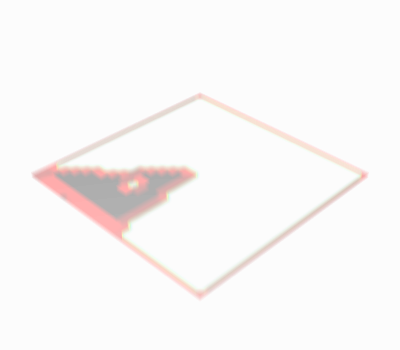

In [250]:
hard_map_array = get_material_map_hard(translated_input, element_size, dimensionality=2)

## Create function to plot the tensor
def plot_2d(sample_array, contour = False, clear = True, edges = np.array([])):
    if clear:
        mlab.clf()
    #print(sample_array)
    m = np.max(np.abs(sample_array))
    print(m, len(sample_array.shape))
    s = np.abs(sample_array)
    mlab.figure(figure=None, bgcolor=(0.99,0.99,0.99), fgcolor=None, engine=None, size=(400, 350))
    
    if len(sample_array.shape)==3:
        
        sample_array = np.concatenate((sample_array, sample_array), axis=2)
        
    sample_array = np.abs(sample_array)

    try:
        sample_array = sample_array/m
    except: ## if m is zero
        pass
    n = np.max(np.abs(sample_array))
    print(n)

    sample_array[0,:,:] += 1.2
    sample_array[:,0,:] += 1.2
    sample_array[-1,:,:] += 1.2
    sample_array[:,-1,:] += 1.2
    
    if edges.size > 0:
        sample_array = sample_array + 0.25*edges
        
    volume = mlab.pipeline.volume(mlab.pipeline.scalar_field(sample_array), vmin=0.2, vmax=0.8)
    if contour:
        mlab.contour3d(s)
    
        
    return volume
plot_2d(hard_map_array)

In the image above, the shaded part represents the points where nodes were detected. The colourful edge is a contour of 'same value' surfaces, which is used to demonstrate where there is sharp transition in values. As can be seen,  it works roughly as expected, however the edges are jagged and some spots in the center where the nodes are very far apart, the tensor actually sees no nodes and receive a zero value. To correct this, it can be filtered with a convolutional kernel to create an average value for every point, smoothing out the edges and filling the internal elements that are empty.

Note: the top left of the image shows no "gradient" because it is on the very edge of the tensor

In [251]:
## create a function that creates a fuzzy map of where the element is
def interpolate_array_spatially_2D(sample_array):
    ## use gaussian blur kernel to smooth out the tensor
    
    ## define kernel
    kernel_blur = 1/256*torch.Tensor([[1, 4, 6, 4, 1],
                                [4, 16, 24, 16, 4],
                                [6, 24, 36, 24, 6],
                                [4, 16, 24, 16, 4],
                                [1, 4, 6, 4, 1]])
    
    ## add redundant batch_size and _feature dimensions because of torch requirements
    kernel_blur = kernel_blur.view([1,1,5,5])
    
    ## convert
    tensor = torch.from_numpy(sample_array)
    
    ## convolve filter and tensor
    smoothed_array = F.conv2d(input = tensor.view([1,1,32,32]), weight = kernel_blur.double(), stride = 1, padding=2)   
    
    ## return it as a correctly shaped numpy arra
    return smoothed_array.view([32,32,1]).numpy()

In [252]:
## create a function that runs any other arbitrary kernel
def convolve_with_kernel(sample_array, kernel_name='edge_detection'):
    ## use kernel on sample
    
    ## define kernel
    
    if kernel_name == 'edge_detection':
        kernel = torch.Tensor([[-1,-1,-1],
                              [-1,8,-1],
                              [-1,-1,-1]])
    
    ## add redundant batch_size and _feature dimensions because of torch requirements
    kernel = kernel.view([1,1,3,3])
    
    ## convert
    tensor = torch.from_numpy(sample_array)
    
    ## convolve filter and tensor
    convolved_array = F.conv2d(input = tensor.view([1,1,32,32]), weight = kernel.double(), stride = 1, padding=1)   
    
    ## return it as a correctly shaped numpy array
    return convolved_array.view([32,32,1]).numpy()
                               

1.0 3
1.0



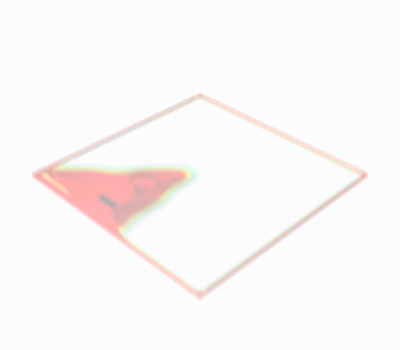

In [253]:
#tic = time.time()
smoothed_map_array = interpolate_array_spatially_2D(hard_map_array)
#print(time.time()-tic)
plot_2d(smoothed_map_array)

8.0 3
1.0



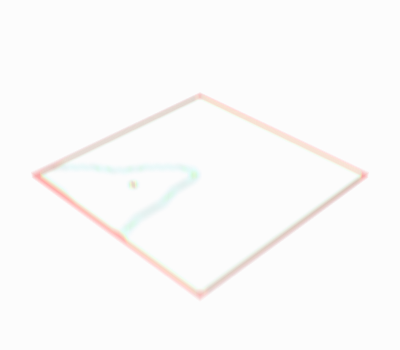

In [254]:
plot_2d(convolve_with_kernel(hard_map_array))

The other features depend on the type of feature they are. Specifically, displacements have a value that vary spacially according to a shape function which in theory can be specified, however for the sake of simplicity and performance, they are going to be interpolated linearly. Forces on the element, on the other hand, are vector sums of the nodal forces.

In [255]:
## create a function that gets a sample dataframe and transforms it into an array

def get_input_map(translated_sample_df, element_size, hard_map, dimensionality=2):
    ## takes a dataframe and returns the displacements and forces in every element of the tensor

    ##Initialize an array for this feature
    array = create_array(dimensionality, features=6, resolution = 32)
    #print(array.shape)

    
    ## Create iterator for the array
    arr_iterator = np.nditer(array, flags=['multi_index'])
    
    ## create 2d array
    hard_map_matrix = hard_map[:,:,0]
    
    ## iterates through every  element of array
    update = False
    for location in arr_iterator:
        if dimensionality == 2:
            x = arr_iterator.multi_index[0]
            y = arr_iterator.multi_index[1]
            z=0
            feature = arr_iterator.multi_index[2]
        else:
            raise Exception('3d not implemented yet')
        
        
        if dimensionality == 2 and  hard_map_matrix[x,y] > 0.0: 
            ## get the indices for this location
            indices = get_dataframe_indices(element_size, translated_sample_df, x, y, z)

            ## calculates the feature value based on current feature being analyzed
            if 0 <= feature < 3: 
                displacements = translated_sample_df.loc[indices,['x_disp','y_disp','z_disp']].values
                if displacements.size > 0:
                    feature_value = displacements[:,feature].mean()
                    update=True
                    
            if 3 <= feature < 6: 
                forces = translated_sample_df.loc[indices,['x_force','y_force','z_force']].values
                if forces.size > 0:
                    feature_value = forces[:,feature-3].sum()
                    update = True
                    
            if update:
                array[x,y,feature] = feature_value
                update = False
                
        elif dimensionality != 2:
            raise Exception('3d not implemented yet')    


    return array
tic = time.time()
input_feature_array = get_input_map(warning_df, element_size, hard_map_array, dimensionality=2)
print(time.time()-tic)

1.0920274257659912


Timing the above function, it seems that the major part of the time loss comes from getting the indices. We'll try to find a way to reduce that, as 8-10 seconds for a sample of this size is too much, since this has to be scaled to take samples as much as 10 times larger. It is obvious that this time comes from the .get_dataframe_indices() function, and thus that is where the improvements have to be made. After changing that function the time was lowered to 2 seconds. This can further be lowered by making sure to only call the get_dataframe_indices function where there is a possibility of there being a piece of material, using the hard map array. By doing that, the necessity to check for the list length is also  remove, which cuts the processing time further to 0.95 seconds approximately. 

(32, 32, 1)
0.00138249664993752 3
1.0



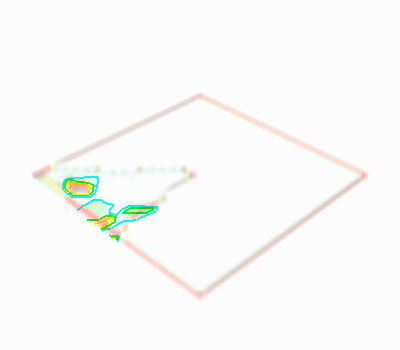

In [256]:
print(input_feature_array[:,:,0:1].shape)
edges = convolve_with_kernel(hard_map_array)
plot_2d(input_feature_array[:,:,0:1],contour=True, clear=False, edges=edges)

0.0018157012491464898 3
1.0



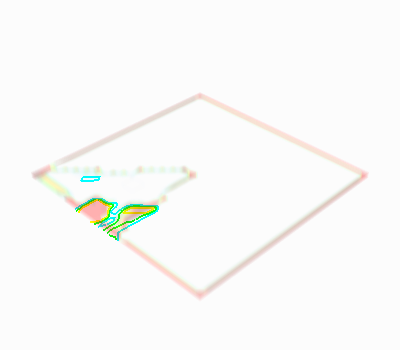

In [257]:
plot_2d(input_feature_array[:,:,1:2],contour=True,edges=edges)

590.47128195359 3
1.0



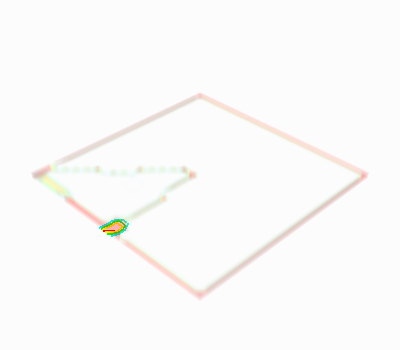

In [258]:
plot_2d(input_feature_array[:,:,3:4],contour=True,edges=edges)

487.4631351553655 3
1.0



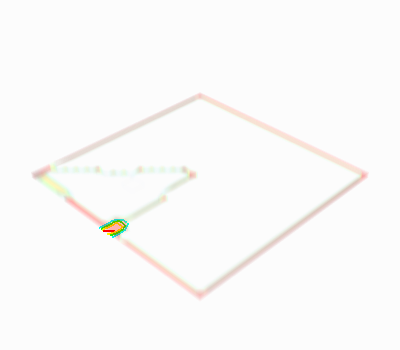

In [259]:
plot_2d(input_feature_array[:,:,4:5],contour=True,edges=edges)

Now, similarly, the output map must be built

In [260]:
_ , raw_output_data_octant = scale.get_sample_dfs(data_folder_path, 94)

In [261]:
translated_output = translate_df(raw_output_data_octant, max_dims)
translated_output

,node_number,x_loc,y_loc,z_loc,x_disp,y_disp,z_disp
0,1,1.728600,0.94477,0.0,0.001270,-0.001291,0.0
1,2,1.632988,0.00000,0.0,0.002493,0.000889,0.0
2,3,1.723557,0.89495,0.0,-0.000116,-0.000800,0.0
3,4,1.718515,0.84512,0.0,0.000461,-0.001007,0.0
4,5,1.713473,0.79530,0.0,0.000514,0.000104,0.0
...,...,...,...,...,...,...,...
468,469,1.169198,0.72049,0.0,-0.000375,0.000759,0.0
469,470,1.064728,0.72427,0.0,-0.000338,0.000258,0.0
470,471,1.455548,0.35252,0.0,0.001127,-0.000002,0.0
471,472,1.586564,0.74267,0.0,-0.000681,0.001816,0.0


In [262]:
def get_output_map(translated_sample_df, element_size,hard_map, dimensionality=2):
    ## takes a dataframe and returns the displacements in every element of the tensor
    
    ##Initialize an array for this feature
    array = create_array(dimensionality, features=3, resolution = 32)
    #print(array.shape)
    
    ## Create iterator for the array
    arr_iterator = np.nditer(array, flags=['multi_index'])
    
    ## Create 2d array
    hard_map_matrix = hard_map[:,:,0]
    
    update=False
    ## iterates through every  element of array
    for location in arr_iterator:
        
        if dimensionality == 2:
            x = arr_iterator.multi_index[0]
            y = arr_iterator.multi_index[1]
            z=0
            feature = arr_iterator.multi_index[2]
        else:
            raise Exception('3d not implemented yet')
        
        ## get the indices for this location
        indices = get_dataframe_indices(element_size, translated_sample_df, x, y, z)
        if dimensionality == 2 and  hard_map_matrix[x,y] > 0.0: ## empty list returns False
            ##gets the features of the input at that location
            displacements = translated_sample_df.loc[indices,['x_disp','y_disp','z_disp']].values
            
            if displacements.size > 0:
                ## calculates the feature value based on current feature being analyzed
                feature_value = displacements[:,feature].mean()
                update=True

            if update:
                array[x,y,feature] = feature_value
                update=False
                
        elif dimensionality > 2:
            raise Exception('3d not implemented yet')    
                
            
    return array
tic = time.time()
output_feature_array = get_output_map(translated_output, element_size,hard_map_array, dimensionality=2)
print(time.time()-tic)

0.6243329048156738


0.0023668 3
1.0



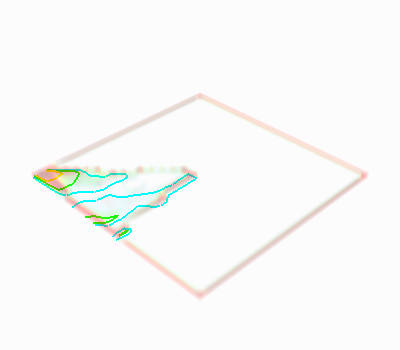

In [263]:
plot_2d(output_feature_array[:,:,0:1],contour=True, clear=False, edges=edges)

0.0018157 3
1.0



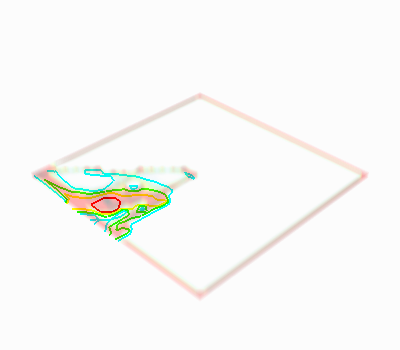

In [264]:
plot_2d(output_feature_array[:,:,1:2],contour=True, clear=False, edges=edges)

Now having all the feature tensors/arrays, we need to concatenate them into a representative shape.

In [265]:
## create a function that takes a sample and returns the concatenated, unscaled arrays
def create_unscaled_arrays(data_folder_path, max_dimensions, sample_number, element_size, dimensionality=2):
    ## gets the data from a sample dataframe and returns the input and output array
    
    # get dataframes
    raw_input_df, raw_output_df = scale.get_sample_dfs(data_folder_path, sample_number)
    
    # translate dataframes
    translated_input_df = translate_df(raw_input_df, max_dimensions)
    translated_output_df = translate_df(raw_output_df, max_dimensions)

    
    # get material existence feature
    material_existence = get_material_map_hard(translated_input_df, element_size, dimensionality)
    material_existence = interpolate_array_spatially_2D(material_existence)

    
    # get input and output feature arrays
    input_features_array = get_input_map(translated_input_df, element_size, material_existence, dimensionality)
    output_features_array = get_output_map(translated_output_df, element_size,material_existence, dimensionality)

    
    # concatenate into arrays
    concatenated_input = np.concatenate((material_existence, input_features_array), axis = 2)
    concatenated_output = np.concatenate((material_existence, output_features_array), axis = 2)

    
    return concatenated_input, concatenated_output

tic = time.time()

concat_input, concat_output = create_unscaled_arrays(data_folder_path,  max_dims, 94, element_size, dimensionality = 2)

print(time.time()-tic)

2.967921733856201


One thing I've come to realize is that the way this is being done requires the computation to "touch" all the elements in the dataframe each time it has to check what the conditions are for a particular location in the tensor. An alternative would be to, instead of iterating through the tensor, iterate through the dataframe, and dynamically update the tensor for each new point. This removes the need for almost all of the if statements used as they are needed to control whether a certain location in the tensor contains selections. Alternatively, by iterating through the dataframe it is guaranteed that any point we go to in the tensor is by definition a material point. We need a function that gets the tensor location based on the coordinates in the dataframe,  and then gets all the data relevant to that dataframe location and correctly update the tensor based on it.

9.14 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.0 3
1.0



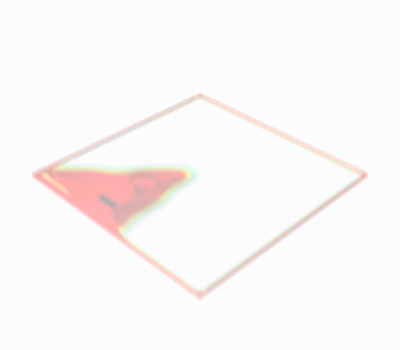

In [421]:
## Create function that takes a sample df and returns the concatenated array
def create_concat_array(sample_df, empty_array, element_size, dataframe_type):
    ## takes a sample dataframe and creates the concatenated tensor with it
    
    ## initialize empty array copy
    concat_array = empty_array.copy()
    
    ## get resolution of array
    resolution = len(empty_array[0])

    ## check dimensionality of array
    if len(concat_array.shape) == 3:
        dimensionality = 2
        
    if len(concat_array.shape) == 4:
        dimensionality = 3

    ## create dictionary to store number of nodes for each array location
    nodes_dictionary = {}
    
    for i, row in enumerate(sample_df.itertuples()): #itertuples is much faster than iterrows
        ## get spacial locations
        x_loc, y_loc, z_loc = row.x_loc, row.y_loc, row.z_loc
        
        ## calculate tensor locations
        ## points at the very edge of an element at the edge of the array 
        ## should fall to the previous index, not to the next
        x = x_loc / element_size 
        y = y_loc / element_size 
        z = z_loc / element_size
        
        x,y,z = int(x), int(y), int(z)
        
        
        ## check for upper edge case
        if  x >= resolution:
            x -= 1
        if  y >= resolution:
            y -= 1
        if  z >= resolution:
            z -= 1
        
        
        ## create feature vector to update location
        if dataframe_type.lower() == 'input':
            feature_vector = np.array([1, row.x_disp, row.y_disp, row.z_disp, row.x_force, row.y_force, row.z_force])
            
        if dataframe_type.lower() == 'output':
            feature_vector = np.array([1, row.x_disp, row.y_disp, row.z_disp])
            
        elif dataframe_type.lower() != 'input':
            raise Exception(f'Incorrect dataframe type. Expected \'input\' or \'output\', got {dataframe_type}')
       
        ## update values at location
        if dimensionality == 2:
            
           
            try:
                 ## update material existence
                concat_array[x,y,0] = feature_vector[0]
                
                ## only do operation if there is a value to add
                if any(feature_vector[1:] != 0.0):
                    
                    if any(feature_vector[1:4] != 0.0):
                        ## add displacements
                        concat_array[x,y,1:4] += feature_vector[1:4]

                        ## add item to dictionary
                        ## control whether to create or update dictionary entry
                        if (x,y) in nodes_dictionary:
                            nodes_dictionary[(x,y)] +=1
                        else:
                            nodes_dictionary[(x,y)] = 1
                    
                    ## add forces if input
                    if dataframe_type.lower() == 'input':
                        concat_array[x,y,4:7] += feature_vector[4:7]
                
            except IndexError:
                print(f'out of bounds, check sample at x:{x_loc} y:{y_loc} z:{z_loc}, indices {x,y,z}')
               
            
            
        elif dimensionality > 2:
            raise Exception(f'Three dimensional or higher not implemented yet')
        
        
        
    ## divide the displacements by the number of nodes
    for key in nodes_dictionary.keys():
        #print(concat_array[*key,1], concat_array[*key,1]/nodes_dictionary[key])
        concat_array[(*key, [1,2,3])] = concat_array[(*key, [1,2,3])]/nodes_dictionary[key]
    
    
    ## smooth out material existence feature
    concat_array[:,:,0:1] = interpolate_array_spatially_2D(concat_array[:,:,0:1])
    return concat_array


empty_array_input = create_array(dimensionality = 2, features = 7)


%timeit create_concat_array(translated_input, empty_array_input, element_size, dataframe_type = 'input')

concat_array_input = create_concat_array(translated_input, empty_array_input, element_size, dataframe_type = 'input')
plot_2d(concat_array_input[:,:,0:1])



The function above is roughly equivalent to all of get_material_map_hard(), get_smoothed_map(), get_input_map() and with part of the create_unscaled_arrays() function. These functions, when combined for an input, lead to a time per sample of about 2.5 seconds. This new approach takes roughly 10 miliseconds, a 250 times increase in speed (or, for the shock factor, a 8000 times speedup when compared to the first iteration of these functions) Thus, this is a much much better approach to it.

0.00138249664993752 3
1.0



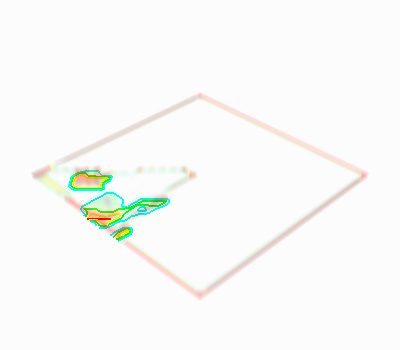

In [416]:
plot_2d(concat_array_input[:,:,1:2],contour=True, clear=False, edges=edges)

0.0018157012491464895 3
1.0



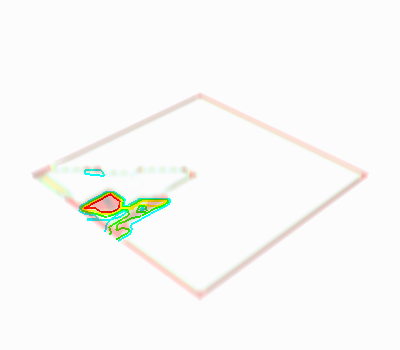

In [417]:
plot_2d(concat_array_input[:,:,2:3],contour=True, clear=False, edges=edges)

590.47128195359 3
1.0



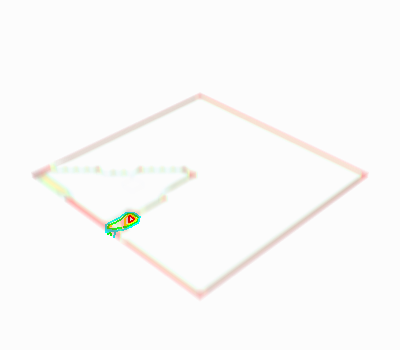

In [418]:
plot_2d(concat_array_input[:,:,4:5],contour=True, clear=False, edges=edges)

487.4631351553655 3
1.0



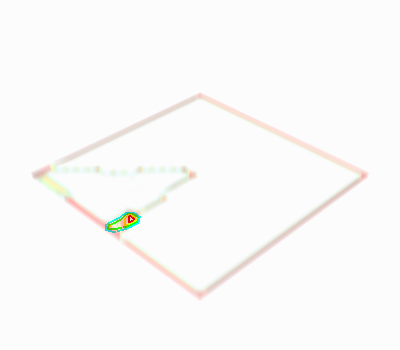

In [419]:
plot_2d(concat_array_input[:,:,5:6],contour=True, clear=False, edges=edges)

0.0023668 3
1.0



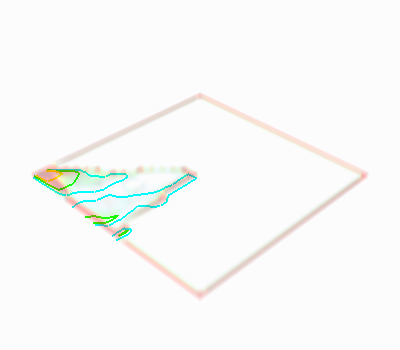

In [425]:
concat_array_output = create_concat_array(translated_output, empty_array_input, element_size, dataframe_type = 'output')
plot_2d(concat_array_output[:,:,1:2],contour=True, clear=False, edges=edges)

0.0018157012491464895 3
1.0



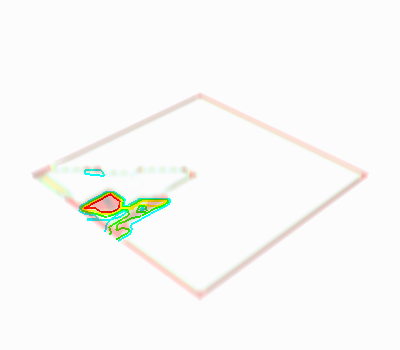

In [426]:
plot_2d(concat_array_input[:,:,2:3],contour=True, clear=False, edges=edges)

Now with this function all we need to do is run through all the samples and save the arrays. Once the unscaled arrays are saved, we need to get the new maximum values in the sample (force only, as the maximum displacement can only be the same, at maximum, as the original displacement since it is an average), and finally scale the arrays and reshape them to the correct dimensions for the ConvNet

In [735]:
## create sample iterator that returns the input and output arrays for each of the samples
def get_unscaled_arrays(data_folder_path, resolution = 32):
    ## takes the path to the folder with all samples and creates
    ## an iterator that goes through all of them and returns the corresponding
    ## array to each sample
    
    with HiddenPrints():
        # get max dimensions for the dataset
        max_dimensions = get_max_dimensions(data_folder_path)
    
    # get element size for this dataset
    element_size = get_element_size(data_folder_path, resolution)
    
    # create an iterator for all samples
    samples_iterator = scale.sample_iterator(data_folder_path)
    
    # create empty arrays to use in functions
    dimensionality = 2
    input_features = 7
    output_features = 4
    empty_arr_input = create_array(dimensionality, input_features, resolution)
    empty_arr_output = create_array(dimensionality, output_features, resolution)
    
    # iterates through all samples
    for sample_number, input_dataframe, output_dataframe in samples_iterator:
        
        
        # translate the data
        translated_input_df = translate_df(input_dataframe, max_dimensions)
        translated_output_df = translate_df(output_dataframe, max_dimensions)
        
        # creates the arrays
        concatenated_input = create_concat_array(translated_input_df, empty_arr_input, element_size, dataframe_type='input')
        concatenated_output = create_concat_array(translated_output_df, empty_arr_output, element_size, dataframe_type='output')
    
        yield sample_number, concatenated_input, concatenated_output
        
data_folder_path =  Path('D:/Ansys Simulations/Project/2D/data')
array_it = get_unscaled_arrays(data_folder_path, resolution = 32)

11


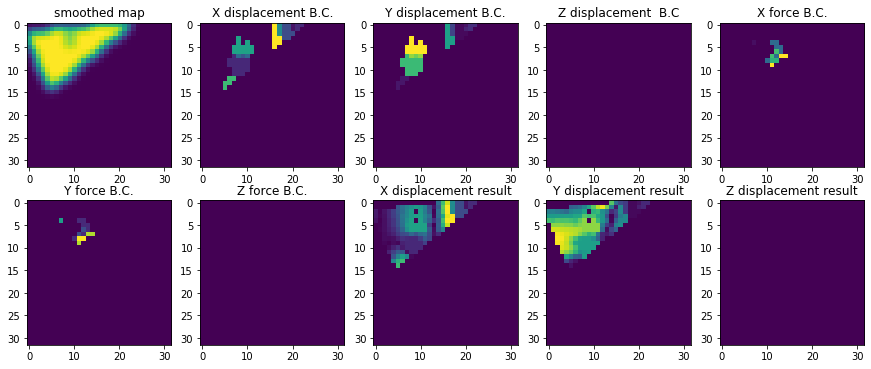

In [691]:
sample_number, concat_input, concat_output = next(array_iterator)
%matplotlib inline 
import matplotlib.pyplot as plt
#f = plt.figure()

f, axarr = plt.subplots(2,5, figsize = (15,6)) 
#plt.imshow(concat_input[:,:,0])
def plot_grid_2d(concat_input):
    axarr[0,0].imshow(np.abs(concat_input[:,:,0]))
    axarr[0,0].set(title='smoothed map')

    axarr[0,1].imshow(np.abs(concat_input[:,:,1]))
    axarr[0,1].set(title='X displacement B.C.')

    axarr[0,2].imshow(np.abs(concat_input[:,:,2]))
    axarr[0,2].set(title='Y displacement B.C.')

    axarr[0,3].imshow(np.abs(concat_input[:,:,3]))
    axarr[0,3].set(title='Z displacement  B.C')

    axarr[0,4].imshow(np.abs(concat_input[:,:,4]))
    axarr[0,4].set(title='X force B.C.')

    axarr[1,0].imshow(np.abs(concat_input[:,:,5]))
    axarr[1,0].set(title='Y force B.C.')

    axarr[1,1].imshow(np.abs(concat_input[:,:,6]))
    axarr[1,1].set(title='Z force B.C.')

    axarr[1,2].imshow(np.abs(concat_output[:,:,1]))
    axarr[1,2].set(title='X displacement result')

    axarr[1,3].imshow(np.abs(concat_output[:,:,2]))
    axarr[1,3].set(title='Y displacement result')

    axarr[1,4].imshow(np.abs(concat_output[:,:,3]))
    axarr[1,4].set(title='Z displacement result')

    print(sample_number)
    plt.show()
    
plot_grid_2d(concat_input)    

Now we need to save the arrays to the correct place

In [777]:
data_folder_path =  Path('D:/Ansys Simulations/Project/2D/data')
array_it = get_unscaled_arrays(data_folder_path, resolution = 32)

## create function to save arrays to correct location
def save_arrays(array_iterator, data_folder_path, save_path=data_folder_path, array_type = 'unscaled'):
    # take the folder where the samples are and the folder where the samples are going to be
    # saved to, create the folder and save the arrays
    
    ## create save path
    save_path = Path(save_path, 'arrays')
    
    ## create save folders
    input_save_path, output_save_path = split.create_folders(save_path)
    
    #sample_number, input_array, output_array = next(array_iterator)
    
    if 'nscaled' in array_type.lower():
        input_file_root = array_type.lower()
        output_file_root = array_type.lower()
        
    elif 'scaled' in array_type.lower():
        input_file_root = array_type.lower()
        output_file_root = array_type.lower()
        
    else:
        raise Exception(f'Expected \'scaled\' or \'unscaled\' strings for argument <array_type>, got \'{array_type}\'')
        
    ## create log file
    log_file = Path(save_path,'log.txt')
    
    with open(log_file, mode = '+w') as log:
        log.write(f"{'SAMPLE': <20} {'INPUT': <20} {'OUTPUT': <20} {'PATH': <20} {'TIME': >40}\n")
        
        initial_time = time.time()
        for sample_number, input_array, output_array in array_iterator:
            tic = time.time()
            input_file_ending = '_input_' + str(sample_number) + '.npy'
            output_file_ending = '_output_' + str(sample_number) + '.npy'
            
            input_array_path = Path(input_save_path, input_file_root + input_file_ending)
            output_array_path = Path(output_save_path, output_file_root + output_file_ending)
            
            
            if not(input_array_path.is_file()) :
                action_input = 'CREATE'
            else:
                action_input = 'OVRWRT'
                
            if not(output_array_path.is_file()):
                action_output = 'CREATE'
            else:
                action_output = 'OVRWRT'
            
            np.save(input_array_path, input_array)
            np.save(output_array_path, output_array)
            
            
            log.write(f'{sample_number: <20} {action_input: <20} {action_output: <20} {str(save_path): <20} {time.time()-tic: >40}s \n')
        
        log.write(f'OVERALL TIME: {time.time()-initial_time}s \n')
        
save_arrays(array_it, data_folder_path, array_type = 'unscaled_2d')

folder D:\Ansys Simulations\Project\2D\data\arrays\input likely already exist
folder D:\Ansys Simulations\Project\2D\data\arrays\output likely already exist
